# Searching Unstructured and Structured Data #
## Assignment 1: Retrieval models [100 points] ##
**TA**: Nikos Voskarides (n.voskarides@uva.nl)

In this assignment you will get familiar with basic information retrieval concepts. You will implement and evaluate different information retrieval ranking models and evaluate their performance.

We provide you with a Indri index. To query the index, you'll use a Python package ([pyndri](https://github.com/cvangysel/pyndri)) that allows easy access to the underlying document statistics.

For evaluation you'll use the [TREC Eval](https://github.com/usnistgov/trec_eval) utility, provided by the National Institute of Standards and Technology of the United States. TREC Eval is the de facto standard way to compute Information Retrieval measures and is frequently referenced in scientific papers.

This is a **groups-of-three assignment**, the deadline is **Monday, 22/1, at 23:59**. Code quality, informative comments and convincing analysis of the results will be considered when grading. Submission should be done through blackboard, questions can be asked on the course [Piazza](https://piazza.com/class/ixoz63p156g1ts).

### Technicalities (must-read!) ###

The assignment directory is organized as follows:
   * `./assignment.ipynb` (this file): the description of the assignment.
   * `./index/`: the index we prepared for you.
   * `./ap_88_90/`: directory with ground-truth and evaluation sets:
      * `qrel_test`: test query relevance collection (**test set**).
      * `qrel_validation`: validation query relevance collection (**validation set**).
      * `topics_title`: semicolon-separated file with query identifiers and terms.

You will need the following software packages (tested with Python 3.5 inside [Anaconda](https://conda.io/docs/user-guide/install/index.html)):
   * Python 3.5 and Jupyter
   * Indri + Pyndri (Follow the installation instructions [here](https://github.com/nickvosk/pyndri/blob/master/README.md))
   * gensim [link](https://radimrehurek.com/gensim/install.html)
   * TREC Eval [link](https://github.com/usnistgov/trec_eval)

### TREC Eval primer ###
The TREC Eval utility can be downloaded and compiled as follows:

    git clone https://github.com/usnistgov/trec_eval.git
    cd trec_eval
    make

TREC Eval computes evaluation scores given two files: ground-truth information regarding relevant documents, named *query relevance* or *qrel*, and a ranking of documents for a set of queries, referred to as a *run*. The *qrel* will be supplied by us and should not be changed. For every retrieval model (or combinations thereof) you will generate a run of the top-1000 documents for every query. The format of the *run* file is as follows:

    $query_identifier Q0 $document_identifier $rank_of_document_for_query $query_document_similarity $run_identifier
    
where
   * `$query_identifier` is the unique identifier corresponding to a query (usually this follows a sequential numbering).
   * `Q0` is a legacy field that you can ignore.
   * `$document_identifier` corresponds to the unique identifier of a document (e.g., APXXXXXXX where AP denotes the collection and the Xs correspond to a unique numerical identifier).
   * `$rank_of_document_for_query` denotes the rank of the document for the particular query. This field is ignored by TREC Eval and is only maintained for legacy support. The ranks are computed by TREC Eval itself using the `$query_document_similarity` field (see next). However, it remains good practice to correctly compute this field.
   * `$query_document_similarity` is a score indicating the similarity between query and document where a higher score denotes greater similarity.
   * `$run_identifier` is an identifier of the run. This field is for your own convenience and has no purpose beyond bookkeeping.
   
For example, say we have two queries: `Q1` and `Q2` and we rank three documents (`DOC1`, `DOC2`, `DOC3`). For query `Q1`, we find the following similarity scores `score(Q1, DOC1) = 1.0`, `score(Q1, DOC2) = 0.5`, `score(Q1, DOC3) = 0.75`; and for `Q2`: `score(Q2, DOC1) = -0.1`, `score(Q2, DOC2) = 1.25`, `score(Q1, DOC3) = 0.0`. We can generate run using the following snippet:

In [397]:
import time
import numpy as np
%matplotlib inline
import pandas as pd
import logging
import os
import pyndri
import collections
import io
import sys
from scipy import spatial
import copy
import gensim

In [396]:
def write_run(model_name, data, out_f,
              max_objects_per_query=sys.maxsize,
              skip_sorting=False):
    """
    Write a run to an output file.
    Parameters:
        - model_name: identifier of run.
        - data: dictionary mapping topic_id to object_assesments;
            object_assesments is an iterable (list or tuple) of
            (relevance, object_id) pairs.
            The object_assesments iterable is sorted by decreasing order.
        - out_f: output file stream.
        - max_objects_per_query: cut-off for number of objects per query.
    """
    empty_rankings = 0
    
    for subject_id, object_assesments in data.items():
        if not object_assesments:
            empty_rankings = empty_rankings+1
            logging.warning('Received empty ranking for %s; ignoring.',
                            subject_id)
            continue


        # Probe types, to make sure everything goes alright.
        # assert isinstance(object_assesments[0][0], float) or \
        #     isinstance(object_assesments[0][0], np.float32)
        #print("object_assesments[0][1] is ")
        #print(object_assesments[0][1])
        if (not(isinstance(object_assesments[0][1], str) or \
            isinstance(object_assesments[0][1], bytes))):
            print(object_assesments[0][1])
        
        assert isinstance(object_assesments[0][1], str) or \
            isinstance(object_assesments[0][1], bytes)

        if not skip_sorting:
            object_assesments = sorted(object_assesments, reverse=True)

        if max_objects_per_query < sys.maxsize:
            object_assesments = object_assesments[:max_objects_per_query]

        if isinstance(subject_id, bytes):
            subject_id = subject_id.decode('utf8')

        for rank, (relevance, object_id) in enumerate(object_assesments):
            if isinstance(object_id, bytes):
                object_id = object_id.decode('utf8')

            out_f.write(
                '{subject} Q0 {object} {rank} {relevance} '
                '{model_name}\n'.format(
                    subject=subject_id,
                    object=object_id,
                    rank=rank + 1,
                    relevance=relevance,
                    model_name=model_name))
            
            
    print("We got "+str(empty_rankings)+" empty rankings in total")
        #print("Just_finished write_run")
# The following writes the run to standard output.
# In your code, you should write the runs to local
# storage in order to pass them to trec_eval.
write_run(
    model_name='example',
    data={
        'Q1': ((1.0, 'DOC1'), (0.5, 'DOC2'), (0.75, 'DOC3')),
        'Q2': ((-0.1, 'DOC1'), (1.25, 'DOC2'), (0.0, 'DOC3')),
    },
    out_f=sys.stdout,
    max_objects_per_query=1000)

Q1 Q0 DOC1 1 1.0 example
Q1 Q0 DOC3 2 0.75 example
Q1 Q0 DOC2 3 0.5 example
Q2 Q0 DOC2 1 1.25 example
Q2 Q0 DOC3 2 0.0 example
Q2 Q0 DOC1 3 -0.1 example
We got 0 empty rankings in total


### Pyndri primer ###
For this assignment you will use [Pyndri](https://github.com/cvangysel/pyndri) [[1](https://arxiv.org/abs/1701.00749)], a python interface for [Indri](https://www.lemurproject.org/indri.php). We have indexed the document collection and you can query the index using Pyndri. We will start by giving you some examples of what Pyndri can do:

First we read the document collection index with Pyndri:

In [398]:
index = pyndri.Index('index/')
doc_no = index.maximum_document() - index.document_base()
token2id, id2token, _ = index.get_dictionary()
print([id2token[word_id] for word_id in example_document[1] if word_id > 0])
print("There are %d documents in this collection." % (index.maximum_document() - index.document_base()))

['52', 'students', 'arrested', 'takeover', 'university', 'massachusetts', 'building', 'fifty', 'two', 'students', 'arrested', 'tuesday', 'evening', 'occupying', 'university', 'massachusetts', 'building', 'overnight', 'protest', 'defense', 'department', 'funded', 'research', 'new', 'york', 'city', 'thousands', 'city', 'college', 'students', 'got', 'unscheduled', 'holiday', 'demonstrators', 'occupied', 'campus', 'administration', 'building', 'protest', 'possible', 'tuition', 'increases', 'prompting', 'officials', 'suspend', 'classes', '60', 'police', 'riot', 'gear', 'arrived', 'university', 'massachusetts', '5', 'p', 'm', 'two', 'hours', 'later', 'bus', 'drove', 'away', '29', 'students', 'camped', 'memorial', 'hall', 'students', 'charged', 'trespassing', '23', 'students', 'arrested', 'lying', 'bus', 'prevent', 'leaving', 'police', '300', 'students', 'stood', 'building', 'chanting', 'looking', 'students', 'hall', 'arrested', '35', 'students', 'occupied', 'memorial', 'hall', '1', 'p', 'm',

### Task 1: Implement and compare lexical IR methods [40 points] ### 

In this task you will implement a number of lexical methods for IR using the **Pyndri** framework. Then you will evaluate these methods on the dataset we have provided using **TREC Eval**.

Use the **Pyndri** framework to get statistics of the documents (term frequency, document frequency, collection frequency; **you are not allowed to use the query functionality of Pyndri**) and implement the following scoring methods in **Python**:

- [TF-IDF](http://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html). **[5 points]**
- [BM25](http://nlp.stanford.edu/IR-book/html/htmledition/okapi-bm25-a-non-binary-model-1.html) with k1=1.2 and b=0.75. **[5 points]**
- Language models ([survey](https://drive.google.com/file/d/0B-zklbckv9CHc0c3b245UW90NE0/view))
    - Jelinek-Mercer (explore different values of 𝛌 in the range [0.1, 0.5, 0.9]). **[10 points]**
    - Dirichlet Prior (explore different values of 𝛍 [500, 1000, 1500]). **[5 points]**
    - Absolute discounting (explore different values of 𝛅 in the range [0.1, 0.5, 0.9]). **[5 points]**
    
Implement the above methods and report evaluation measures (on the test set) using the hyper parameter values you optimized on the validation set (also report the values of the hyper parameters). Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

For the language models, create plots showing `NDCG@10` with varying values of the parameters. You can do this by chaining small scripts using shell scripting (preferred) or execute trec_eval using Python's `subprocess`.

Compute significance of the results using a [two-tailed paired Student t-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html) **[10 points]**. Be wary of false rejection of the null hypothesis caused by the [multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). There are multiple ways to mitigate this problem and it is up to you to choose one.

Analyse the results by identifying specific queries where different methods succeed or fail and discuss possible reasons that cause these differences. This is *very important* in order to understand how the different retrieval functions behave.

**NOTE**: Don’t forget to use log computations in your calculations to avoid underflows. 

**IMPORTANT**: You should structure your code around the helper functions we provide below.

### Building run files

In [24]:
def run_retrieval(model_name, score_fn):                 #from global dictionary of results
    """
    Runs a retrieval method for all the queries and writes the TREC-friendly results in a file.
    
    :param model_name: the name of the model (a string)
    :param score_fn: the scoring function (a function - see below for an example) 
    """
    #print(scores_tuple)
    
    column = get_column(score_fn)
    if column==-1:
        print("Run retrieval: cannot identify score function "+str(score_fn))
        return
    else:
        print("Yey, column is "+str(column))
    run_out_path = './run_files/{}.run'.format(model_name) 

    if os.path.exists(run_out_path):
        print("File "+str(run_out_path)+" already exists, operation aborted")
        return

    retrieval_start_time = time.time()

    print('Retrieving using', model_name)
    data = {} 
    noq=0    
    for query_id in tokenized_queries: 
        noq = noq + 1
        temp_list = []
        #print("Query "+str(query_id)+" no "+str(noq)+": got "+str(len(rel_docs[str(query_id)]))+" rel_docs")
        for rel_doc2 in rel_docs[str(query_id)]:
            rel_doc2=int(rel_doc2)
            #print(rel_doc2)
            temp_list.append((scores_tuple[str(query_id), rel_doc2][column], index.document(rel_doc2)[0]))
            data[query_id] = temp_list
        print("Query no "+str(noq)+" is finished")
    
    ##################################################
          
    # The dictionary data has the form: query_id --> (document_score, external_doc_id)
    
        
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,
            max_objects_per_query=1000)     

In [ ]:
with open('./ap_88_89/topics_title', 'r') as f_topics:
    queries = parse_topics([f_topics])

index = pyndri.Index('index/')

num_documents = index.maximum_document() - index.document_base()
print("Number of documents: ", num_documents)

dictionary = pyndri.extract_dictionary(index)

tokenized_queries = {
    query_id: [dictionary.translate_token(token)
               for token in index.tokenize(query_string)
               if dictionary.has_token(token)]
    for query_id, query_string in queries.items()}
 
print("Length of tokenized queries: ", len(tokenized_queries))

query_term_ids = set(
    query_term_id
    for query_term_ids in tokenized_queries.values()
    for query_term_id in query_term_ids)

print("Length of query term ids: ", len(query_term_ids))

# print('Gathering statistics about', len(query_term_ids), 'terms.')

# inverted index creation

document_lengths = {}
unique_terms_per_document = {}

inverted_index = collections.defaultdict(dict)
collection_frequencies = collections.defaultdict(int)

total_terms = 0

for int_doc_id in range(index.document_base(), index.maximum_document()):
    ext_doc_id, doc_token_ids = index.document(int_doc_id)

    document_bow = collections.Counter(
        token_id for token_id in doc_token_ids
        if token_id > 0)
    document_length = sum(document_bow.values())

    document_lengths[int_doc_id] = document_length
    total_terms += document_length

    unique_terms_per_document[int_doc_id] = len(document_bow)

    for query_term_id in query_term_ids:
        assert query_term_id is not None

        document_term_frequency = document_bow.get(query_term_id, 0)

        if document_term_frequency == 0:
            continue

        # frequency of a term in all documents
        collection_frequencies[query_term_id] += document_term_frequency
        # frequency of a term in a particcollections.defaultdict(dict)ular document
        inverted_index[query_term_id][int_doc_id] = document_term_frequency

avg_doc_length = total_terms / num_documents
print("Average document length: ", avg_doc_length)

### Retrieval models

In [16]:
# scoring functions

def tfidf(int_document_id, query_term_id, document_term_freq):
    """
    Scoring function for a document and a query term
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term 
    """ 
    # TODO implement the function
    
    idf = np.log(num_documents / collection_frequencies[query_term_id])
    tf = np.log(1 + document_term_freq)
    score = tf*idf
    return score


#idf = math.log(num_documents) - math.log(df)

def word2vec_similarity(query_id, doc_id, mode):
    if mode=='avg':
        result = 1 - spatial.distance.cosine(vec_query(query_id), vec_doc(doc_id))
        return result
         
def jelinek_mercer(int_document_id, query_term_id, document_term_freq, l):
    base = (l*document_term_freq)/document_lengths[int_document_id] 
    smooth = ((1-l)*collection_frequencies[query_term_id]/ total_terms)
    return np.logaddexp(base, smooth)

def bm25(int_document_id, query_term_id, document_term_freq):
    k1 = 1.2
    b = 0.75
    ld = document_lengths[int_document_id]
    lavg = avg_doc_length
    tf = document_term_freq
    df = collection_frequencies[query_term_id]
    # +
    idf = np.log(num_documents / collection_frequencies[query_term_id])
    # +
    score = (k1+1)*tf*idf/(k1*((1-b)+b*(ld/lavg))+tf)
    return score

def abs_discounting(int_document_id, query_term_id, tf, d):
    #d = 0.1, 0.5, 0.9
    df =  collection_frequencies[query_term_id]
    pwc = df/doc_no  # ( tf(w;C)/|C| )
    doc_length = document_lengths[int_document_id]
    doc_length_unique = unique_terms_per_document[int_document_id]
    base = np.maximum(tf-d, 0)/doc_length
    smooth = (d*doc_length_unique/doc_length)*pwc
    return np.logaddexp(base, smooth) 

def dirichlet_prior(int_document_id, query_term_id, tf, mu):
#     base = (document_term_freq)/(document_lengths[int_document_id] + mu)
#     smooth = (mu*collection_frequencies[query_term_id])/(document_lengths[int_document_id] + mu) 
    df = collection_frequencies[query_term_id]
    pwc = df/doc_no
    #collection_frequencies[query_term_id] instead of pwc
    doc_length = document_lengths[int_document_id] 
    base = ((doc_length)/(doc_length + mu))*(tf/doc_length)
    smooth = (mu*(pwc))/(doc_length + mu)
    return np.logaddexp(base, smooth) 

def vec_query_lsm(query_id, model):
    query_tokens = [id2token[int(word_id)] for word_id in tokenized_queries[str(query_id)] if word_id > 0]
    query_bow = dictionary.doc2bow(query_tokens)
    # infer topic distributions on new, unseen documents
    query_vec = [x[1] for x in model[query_bow]]
    return query_vec

def vec_doc_lsm(int_document_id, model):
    doc_tokens = [word_id for word_id in index.document(int(int_document_id))[1] if word_id > 0]
    # infer topic distributions on new, unseen documents
    doc_bow = dictionary.doc2bow(doc_tokens)
    doc_vec = [x[1] for x in model[doc_bow]]
    return doc_vec

def lsi(int_document_id, query_id):
    result = 1 - spatial.distance.cosine(vec_query_lsm(int(query_id), lsi_model), vec_doc_lsm(int_document_id, lsi_model))
    return result

def lda(int_document_id, query_id):
    result = 1 - spatial.distance.cosine(vec_query_lsm(int(query_id), lda_model), vec_doc_lsm(int_document_id, lda_model))
    return result

In [57]:
# part 1 (scores tuple)

mode='avg'
no=0
scores_tuple = collections.defaultdict(dict)
rel_docs = collections.defaultdict(dict)

for query_id in tokenized_queries: 
    no+=1
    print("Query "+str(no)+" of 150")
    temp_rel_docs = set()
    for query_term_id in tokenized_queries[query_id]:
        part2 = inverted_index[query_term_id]
        for rel_doc in part2:
            temp_rel_docs.add(str(rel_doc))
            tf = inverted_index[query_term_id][rel_doc]
            if not (scores_tuple[query_id, rel_doc]):                #empty list - not yet initialized
                scores_tuple[query_id, rel_doc] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   #13 dims     
            scores_tuple[query_id, rel_doc][0] += tfidf(rel_doc, query_term_id, tf)
            scores_tuple[query_id, rel_doc][1] += dirichlet_prior(rel_doc, query_term_id, tf, mu=500)
            scores_tuple[query_id, rel_doc][2] += dirichlet_prior(rel_doc, query_term_id, tf, mu=1000)
            scores_tuple[query_id, rel_doc][3] += dirichlet_prior(rel_doc, query_term_id, tf, mu=1500)
            scores_tuple[query_id, rel_doc][4] += bm25(rel_doc, query_term_id, tf)
            scores_tuple[query_id, rel_doc][5] += abs_discounting(rel_doc, query_term_id, tf, d=0.1)
            scores_tuple[query_id, rel_doc][6] += abs_discounting(rel_doc, query_term_id, tf, d=0.5)
            scores_tuple[query_id, rel_doc][7] += abs_discounting(rel_doc, query_term_id, tf, d=0.9)
            scores_tuple[query_id, rel_doc][8] += jelinek_mercer(rel_doc, query_term_id, tf, l=0.1)
            scores_tuple[query_id, rel_doc][9] += jelinek_mercer(rel_doc, query_term_id, tf, l=0.5)
            scores_tuple[query_id, rel_doc][10] += jelinek_mercer(rel_doc, query_term_id, tf, l=0.9)
    rel_docs[query_id] = temp_rel_docs

In [ ]:
no=0
for query_id in tokenized_queries: 
    no+=1
    print("Query ("+str(query_id)+"), no"+str(no)+" of 150")
    for rel_doc in rel_docs[query_id]:
        #print("Rel_doc "+str(rel_doc))
        rel_doc = int(rel_doc)
        scores_tuple[query_id, rel_doc][11] = lsi(rel_doc, query_id)

In [ ]:
for query_id in tokenized_queries: 
    no+=1
    print("Query ("+str(query_id)+"), no"+str(no)+" of 150")
    for rel_doc in rel_docs[query_id]:
        rel_doc = int(rel_doc)
        scores_tuple2[query_id, rel_doc][12] = word2vec_similarity(query_id, rel_doc, "avg")
        #scores_tuple2[query_id, rel_doc][0] = lsi_similarity(query_id, rel_doc, "avg")
        break
    break

In [ ]:
def get_column(scorefn_name):
    if scorefn_name=="tfidf":
        print("get_col: tfidf")
        return 0
    elif scorefn_name=="d500":
        print("get_col: d500")
        return 1
    elif scorefn_name=="d1000":
        print("get_col: d1000")
        return 2
    elif scorefn_name=="d1500":
        print("get_col: d1500")
        return 3
    elif scorefn_name=="bm25":
        print("get_col: bm25")
        return 4
    elif scorefn_name=="abs01":
        print("get_col: abs01")
        return 5
    elif scorefn_name=="abs05":
        print("get_col: abs05")
        return 6
    elif scorefn_name=="abs09":
        print("get_col: abs09")
        return 7 
    elif scorefn_name=="jm01":
        print("get_col: jm01")
        return 8
    elif scorefn_name=="jm05":
        print("get_col: jm05")
        return 9
    elif scorefn_name=="jm09":
        print("get_col: jm09")
        return 10
    elif scorefn_name=="lsi":
        print("get_col: lsi")
        return 11
    elif scorefn_name=="w2vavg":
        print("get_col: w2vavg")
        return 12
    else:
        return -1

In [ ]:
run_retrieval('lsi','lsi')

In [58]:
# part 2 (limit to 1000 docs)

retrieval_start_time = time.time()

max_objects_per_query = 1000
data2 = {}
noq=0    

for query_id in tokenized_queries: 
    noq = noq + 1
    temp_list = []
    #print("Query "+str(query_id)+" no "+str(noq)+": got "+str(len(rel_docs[str(query_id)]))+" rel_docs")
    for rel_doc2 in rel_docs[str(query_id)]:
        rel_doc2=int(rel_doc2)
        #print(rel_doc2)
        #temp_list.append((scores_tuple[str(query_id), rel_doc2][0], index.document(rel_doc2)[0]))
        temp_list.append((scores_tuple[str(query_id), rel_doc2][0], index.document(rel_doc2)[0]))
        data2[query_id] = temp_list


    for subject_id, object_assesments in data2.items ():
        #print('Subject_id is '+str(subject_id)+" and object_assessments is "+str(obmax_objects_per_queryject_assesments))
        if max_objects_per_query < sys.maxsize:
            object_assesments = object_assesments[:max_objects_per_query]
            data2[query_id] = object_assesments
    print("Query ("+str(query_id)+"), "+str(noq)+"/150 is finished")
    
print('Data2 creation took', time.time() - retrieval_start_time, 'seconds.')

#proof : len(data2['186']) -> is always gonna be 1000
#also : if u check 'object_assesments' object of each query you'll see it only keeps the highest scores.

#So basically your data is in data2 dictionary:
# data2[query_id] = [(doc1,tfidfscore1), (doc2, tfidfscore2), ... ,(doc1000, tfidfscore1000)]
# data2[query_id] object is a list, and query_id should be provided as a string

Query (199), 1/150 is finished
Query (102), 2/150 is finished
Query (69), 3/150 is finished
Query (106), 4/150 is finished
Query (79), 5/150 is finished
Query (180), 6/150 is finished
Query (52), 7/150 is finished
Query (168), 8/150 is finished
Query (158), 9/150 is finished
Query (85), 10/150 is finished
Query (107), 11/150 is finished
Query (155), 12/150 is finished
Query (59), 13/150 is finished
Query (129), 14/150 is finished
Query (61), 15/150 is finished
Query (182), 16/150 is finished
Query (190), 17/150 is finished
Query (53), 18/150 is finished
Query (132), 19/150 is finished
Query (186), 20/150 is finished
Query (76), 21/150 is finished
Query (87), 22/150 is finished
Query (89), 23/150 is finished
Query (174), 24/150 is finished
Query (141), 25/150 is finished
Query (77), 26/150 is finished
Query (156), 27/150 is finished
Query (78), 28/150 is finished
Query (96), 29/150 is finished
Query (60), 30/150 is finished
Query (116), 31/150 is finished
Query (63), 32/150 is finished


In [ ]:
#data2 in a (q_id, int_doc_id) -> score

q_doc_tfidfs = collections.defaultdict(dict)


for query_id in tokenized_queries:
    for tuple in data2[query_id]:
        q_doc_tfidfs[(query_id, ext_id_mapping[tuple[1]])] = tuple[0]

In [ ]:
q_doc_tfidfs[('100', 10)]

In [237]:
scores_dict = {}

scores_dict['tfidf'] = [v[0] for k, v in scores_tuple.items()]

scores_dict['bm25']  = [v[1] for k, v in scores_tuple.items()]

scores_dict['dirichlet500'] = [v[2] for k, v in scores_tuple.items()]
scores_dict['dirichlet1000'] = [v[3] for k, v in scores_tuple.items()]
scores_dict['dirichlet1500'] = [v[4] for k, v in scores_tuple.items()]

# scores_dict['jelinek01'] = [v[5] for k, v in scores_tuple.items()]
# scores_dict['jelinek05'] = [v[6] for k, v in scores_tuple.items()]
# scores_dict['jelinek09'] = [v[7] for k, v in scores_tuple.items()]

# scores_dict['abs_discounting01'] = [v[8] for k, v in scores_tuple.items()]
# scores_dict['abs_discounting05'] = [v[9] for k, v in scores_tuple.items()]
# scores_dict['abs_discounting09'] = [v[10] for k, v in scores_tuple.items()]


scores_dict['abs_discounting01'] = [v[5] for k, v in scores_tuple.items()]
scores_dict['abs_discounting05'] = [v[6] for k, v in scores_tuple.items()]
scores_dict['abs_discounting09'] = [v[7] for k, v in scores_tuple.items()]


scores_dict['tfidf'][5], scores_dict['bm25'][5]

(1.3259464411605346, 4.5545345241203723)

In [238]:
len(scores_dict)

8

### Validation: Which parameters do include (determine with t-tests on MAP per query)

In [86]:
# scores = pd.DataFrame()
scores_val = {}
# score_names = ['d1000', 'dtfidf', 'abs09', 'd1500', 'bm25', 'abs01', 'abs05', 'd500']

# TODO: JM
score_names = ['d500', 'd1000', 'd1500', 'abs01', 'abs05', 'abs09']
        
for score in score_names:
    score_file = 'scores/val/' + score + '.txt'
#     if score == 'd1000':
#         scores['query_id'] = pd.read_csv(score_file, sep='\t', header=None)[1]
    scores_val[score] = pd.read_csv(score_file, sep='\t', header=None)[2]

In [87]:
scores_val['abs01'][0:5]

0    0.0299
1    0.0484
2    0.0032
3    0.0396
4    0.0004
Name: 2, dtype: float64

### No statistical significance when comparing different hyperparameter value for retrieval functions

In [395]:
scores_val.keys()

dict_keys(['d1000', 'd500', 'd1500', 'abs01', 'abs09', 'abs05'])

In [89]:
# https://stackoverflow.com/questions/29561360/how-to-calculate-p-value-for-two-lists-of-floats
from scipy import stats
import pandas as pd
from itertools import combinations
from statsmodels.sandbox.stats.multicomp import multipletests
p_values = {}


# scores_dict.keys()
for list1, list2 in combinations(scores_val.keys(), 2):
    t, p = stats.ttest_rel(scores_val[list1], scores_val[list2])
    
    comp_name = str(list1) + "_" + str(list2)
    p_values[comp_name] = [p]
    # print(list1, list2, p)
    

p_values = pd.DataFrame(data=p_values).T.reset_index()
p_values.columns = ['models_compared', 'p-value']


p_values_corr = multipletests(list(p_values['p-value']), alpha=0.05, method='bonferroni')
p_values['p_values_corr'] = p_values_corr[1]
p_values['h0_rejected'] = p_values_corr[0]
p_values = p_values.sort_values(by='p_values_corr', ascending=True)
p_values.reset_index(inplace=True, drop=True)
p_values

,models_compared,p-value,p_values_corr,h0_rejected
0,d500_abs01,0.022120,0.331806,False
1,d500_abs05,0.022212,0.333178,False
2,d500_abs09,0.022218,0.333276,False
3,d1000_abs01,0.027514,0.412707,False
4,d1000_abs05,0.027626,0.414383,False
5,d1000_abs09,0.027634,0.414508,False
6,d1500_abs01,0.030619,0.459283,False
7,d1500_abs05,0.030743,0.461139,False
8,d1500_abs09,0.030753,0.461292,False
9,d1000_d500,0.060381,0.905713,False


### As there is no statistical significance in different hyper-parameter values we decide to use the ones with the lowest values

In [90]:
scores_val['d500'].mean(), scores_val['d1000'].mean(), scores_val['d1500'].mean()

(0.1497903225806452, 0.14731612903225808, 0.145941935483871)

In [91]:
scores_val['abs01'].mean(), scores_val['abs05'].mean(), scores_val['abs09'].mean()

(0.09226774193548386, 0.09230967741935484, 0.09231612903225805)

In [92]:
# TODO: JM
# scores['jm01'].mean(), scores['jm05'].mean(), scores['jm09'].mean()

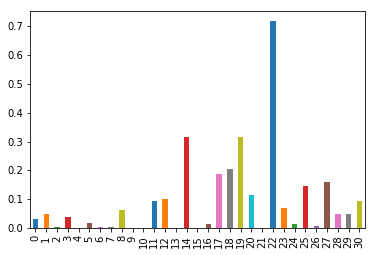

In [227]:
scores_val['abs05'].plot(kind='bar');

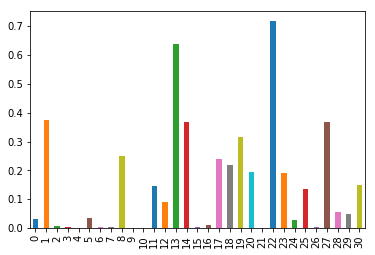

In [228]:
scores_val['d500'].plot(kind='bar');

### On testing:

### Reporting scores (NDCG@10, MAP@1000, Precision@5, Recall@1000)

In [217]:
# scores = pd.DataFrame()
scores_test = pd.DataFrame()
# TODO: JM, LSI, LDA, word2vec
score_names = ['tfidf', 'bm25', 'abs01', 'd500']
        
for score in score_names:
    score_file = 'scores/test/' + score + '_test.txt'
    if score == 'tfidf':
        scores_test['score'] = pd.read_csv(score_file, sep='\t', header=None)[0]
        scores_test['query_id'] = pd.read_csv(score_file, sep='\t', header=None)[1]
    scores_test[score] = pd.read_csv(score_file, sep='\t', header=None)[2]

In [218]:
list(scores_test['score'].unique())

['map                   ',
 'P_5                   ',
 'P_500                 ',
 'recall_1000           ',
 'ndcg_cut_10           ',
 'ndcg_cut_100          ',
 'ndcg_cut_1000         ',
 'map_cut_1000          ',
 'relative_P_5          ',
 'relative_P_500        ']

In [219]:
scores_test['score'] = pd.Series([score .strip() for score in scores_test['score']])
list(scores_test['score'].unique())

['map',
 'P_5',
 'P_500',
 'recall_1000',
 'ndcg_cut_10',
 'ndcg_cut_100',
 'ndcg_cut_1000',
 'map_cut_1000',
 'relative_P_5',
 'relative_P_500']

In [221]:
scoring_metrics = ['ndcg_cut_10', 'map', 'P_5', 'recall_1000']
test_metrics_df = pd.DataFrame()

def get_avg_score(metric):
    df = scores_test[(scores_test['score'] == metric) &  (scores_test['query_id'] == 'all')]
    return df

for scoring_metric in scoring_metrics:
    test_metrics_df = test_metrics_df.append(get_avg_score(scoring_metric), ignore_index=True)
    # print(get_avg_score(scoring_metric))
    
test_metrics_df = test_metrics_df.drop('query_id', axis=1)

In [222]:
test_metrics_df

,score,tfidf,bm25,abs01,d500
0,ndcg_cut_10,0.4000,0.3257,0.1636,0.2479
1,map,0.2114,0.1319,0.0683,0.1137
2,P_5,0.4083,0.3467,0.1667,0.2450
3,recall_1000,0.6432,0.4616,0.3689,0.4617


### Visualization 

In [231]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

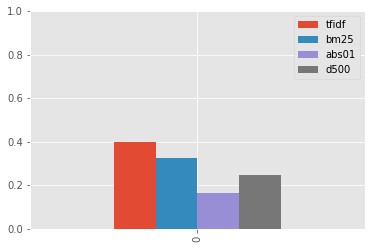

In [232]:
test_metrics_df[test_metrics_df['score'] == 'ndcg_cut_10'][list(test_metrics_df.columns)[1:]].plot(kind='bar', ylim=(0,1));

### Task 2: Latent Semantic Models (LSMs) [20 points] ###

In this task you will experiment with applying distributional semantics methods ([LSI](http://lsa3.colorado.edu/papers/JASIS.lsi.90.pdf) **[5 points]** and [LDA](https://www.cs.princeton.edu/~blei/papers/BleiNgJordan2003.pdf) **[5 points]**) for retrieval.

You do not need to implement LSI or LDA on your own. Instead, you can use [gensim](http://radimrehurek.com/gensim/index.html). An example on how to integrate Pyndri with Gensim for word2vec can be found [here](https://github.com/cvangysel/pyndri/blob/master/examples/word2vec.py). For the remaining latent vector space models, you will need to implement connector classes (such as `IndriSentences`) by yourself.

In order to use a latent semantic model for retrieval, you need to:
   * build a representation of the query **q**,
   * build a representation of the document **d**,
   * calculate the similarity between **q** and **d** (e.g., cosine similarity, KL-divergence).
     
The exact implementation here depends on the latent semantic model you are using. 
   
Each of these LSMs come with various hyperparameters to tune. Make a choice on the parameters, and explicitly mention the reasons that led you to these decisions. You can use the validation set to optimize hyper parameters you see fit; motivate your decisions. In addition, mention clearly how the query/document representations were constructed for each LSM and explain your choices.

In this experiment, you will first obtain an initial top-1000 ranking for each query using TF-IDF in **Task 1**, and then re-rank the documents using the LSMs. Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

Perform significance testing **[5 points]** (similar as in Task 1) in the class of semantic matching methods.

Perform analysis **[5 points]**

In [41]:
import gensim
import pyndri.compat
from gensim import corpora, models, similarities

In [42]:
class IndriCorpus(gensim.interfaces.CorpusABC):

    def __init__(self, index, dictionary, max_documents=None):
        assert isinstance(index, pyndri.Index)

        self.index = index
        self.dictionary = dictionary

        self.max_documents = max_documents

    def _maximum_document(self):
        if self.max_documents is None:
            return self.index.maximum_document()
        else:
            return min(
                self.max_documents + self.index.document_base(),
                self.index.maximum_document())

    def __iter__(self):
        for int_doc_id in range(self.index.document_base(),
                                self._maximum_document()):
            ext_doc_id, tokens = self.index.document(int_doc_id)

            # Compared to IndriSentences, the only difference is the
            # switching of tuple(self.dictionary[token_id] ...) by
            # sorted(collections.Counter(token_id ...).items()).
            yield sorted(collections.Counter(
                token_id
                for token_id in tokens
                if token_id > 0 and token_id in self.dictionary).items())

In [87]:
# docs 1-1000
# index_models = [word_id for word_id in index.document(int(int_document_id))[1] if word_id > 0]
index_models = [index.document(int_doc) for int_doc in range(index.document_base(), index.document_base()+1000)]
# dictionary_models = pyndri.extract_dictionary(index_models)
# corpus_models = IndriCorpus(index_models, dictionary_models)

In [ ]:
corpus = IndriCorpus(index, dictionary)

## LSI model

In [90]:
lsi_model = models.LsiModel(corpus=corpus, id2word=id2token, num_topics=20)
lsi_model.save('/tmp/model.lsi')

In [91]:
lsi_model = models.LsiModel.load('/tmp/model.lsi')

## LDA model

In [92]:
corpora.MmCorpus.serialize('corpus.mm', corpus)

In [93]:
mm = corpora.MmCorpus('corpus.mm')

In [94]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_models, id2word=id2token, num_topics=20, update_every=0, passes=20)
lda_model.save('/tmp/model.lda')

NameError: name 'corpus_models' is not defined

In [ ]:
lda_model = models.LsiModel.load('/tmp/model.lda')

In [ ]:
"""
texts = []
for i in range (index.document_base(),index.maximum_document()):
    # texts[i-1] = ([id2token[word_id] for word_id in index.document(i)[1] if word_id > 0])
    texts.append([id2token[word_id] for word_id in index.document(i)[1] if word_id > 0])

len(texts)

# dictionary_corpus = corpora.Dictionary(texts)
# type(dictionary_corpus)

# get doc bow out of tokenized docs
# corpus_docs = [dictionary_corpus.doc2bow(text) for text in texts]

"""




#### Example LSI

In [ ]:
# query
tokenized_queries['100']

In [ ]:
query_tokens = [id2token[word_id] for word_id in tokenized_queries['100'] if word_id > 0]
query_tokens

In [ ]:
query_bow = dictionary.doc2bow(query_tokens)
query_bow

In [ ]:
query_vec = [x[1] for x in lsi[query_bow]]
query_vec

In [ ]:
from scipy import spatial

def vec_query_lsm(query_id, model):
    query_tokens = [id2token[word_id] for word_id in tokenized_queries[str(query_id)] if word_id > 0]
    query_bow = dictionary.doc2bow(query_tokens)
    # infer topic distributions on new, unseen documents
    query_vec = [x[1] for x in model[query_bow]]
    return query_vec

def vec_doc_lsm(int_document_id, model):
    doc_tokens = [word_id for word_id in index.document(int(int_document_id))[1] if word_id > 0]
    # infer topic distributions on new, unseen documents
    doc_bow = dictionary.doc2bow(doc_tokens)
    doc_vec = [x[1] for x in model[doc_bow]]
    return doc_vec

def lsi(query_id, int_document_id):
    result = 1 - spatial.distance.cosine(vec_query_lsm(query_id, lsi_model), vec_doc_lsm(int_document_id, lsi_model))
    return result

def lda(query_id, int_document_id):
    result = 1 - spatial.distance.cosine(vec_query_lsm(query_id, lda_model), vec_doc_lsm(int_document_id, lda_model))
    return result

In [ ]:
lsi('100', 1)

In [ ]:
lda('100', 1)

In [ ]:
lsi.print_topics(num_topics=5, num_words=5)

In [ ]:
# Text Analytics - Latent Semantic Analysis - https://www.youtube.com/watch?v=BJ0MnawUpaU
# https://radimrehurek.com/gensim/models/lsimodel.html
# https://radimrehurek.com/gensim/wiki.html
# Latent Semantic Analysis in Python - http://blog.josephwilk.net/projects/latent-semantic-analysis-in-python.html
# Building a Vector Space Search Engine in Python - http://blog.josephwilk.net/projects/building-a-vector-space-search-engine-in-python.html
# https://github.com/cvangysel/pyndri/blob/master/examples/word2vec.py
# integrate gensim and pyndri
# https://radimrehurek.com/gensim/tut2.html

### Task 3:  Word embeddings for ranking [10 points] ###

First create word embeddings on the corpus we provided using [word2vec](http://arxiv.org/abs/1411.2738) -- [gensim implementation](https://radimrehurek.com/gensim/models/word2vec.html). You should extract the indexed documents using pyndri and provide them to gensim for training a model (see example [here](https://github.com/nickvosk/pyndri/blob/master/examples/word2vec.py)).

Try one of the following (increasingly complex) methods for building query and document representations:
   * Average or sum the word vectors.
   * Cluster words in the document using [k-means](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) and use the centroid of the most important cluster. Experiment with different values of K for k-means.
   * Using the [bag-of-word-embeddings representation](https://ciir-publications.cs.umass.edu/pub/web/getpdf.php?id=1248).
   
Note that since we provide the implementation for training word2vec, you will be graded based on your creativity on combining word embeddings for building query and document representations.

Note: If you want to experiment with pre-trained word embeddings on a different corpus, you can use the word embeddings we provide alongside the assignment (./data/reduced_vectors_google.txt). These are the [google word2vec word embeddings](https://code.google.com/archive/p/word2vec/), reduced to only the words that appear in the document collection we use in this assignment.

In [ ]:
logging.info('Initializing word2vec.')

word2vec_init = gensim.models.Word2Vec(
    size=20,  # Embedding size
    window=5,  # One-sided window size
    sg=True,  # Skip-gram.
    min_count=5,  # Minimum word frequency.
    sample=1e-3,  # Sub-sample threshold.
    hs=False,  # Hierarchical softmax.
    negative=10,  # Number of negative examples.
    iter=1,  # Number of iterations.
    workers=8,  # Number of workers.
)
with pyndri.open('index/') as index:
    logging.info('Loading vocabulary.')
    dictionary = pyndri.extract_dictionary(index)
    sentences = pyndri.compat.IndriSentences(index, dictionary)

    logging.info('Constructing word2vec vocabulary.')

    # Build vocab.
    word2vec_init.build_vocab(sentences, trim_rule=None)

    model = word2vec_init
    
    model.train(sentences,total_examples=model.corpus_count, epochs=2) 

    model.save('model_20')

logging.info('Trained models: %s', models)

In [ ]:
w2v_model = gensim.models.Word2Vec.load('./word2vec_model/model_20')

In [ ]:
def vec_query(query_id):
    query_vec = []
    for query_term_id in tokenized_queries[query_id]:
        term = id2token[query_term_id]
        try:
            vec = w2v_model[str(term)]
            query_vec.append(vec)
        except Exception:
            pass

    query_avg = np.mean(np.array(query_vec), axis = 0)
    
    return (query_avg)

def vec_doc(doc_id):
    doc_vec = []
    tokens = [id2token[word_id] for word_id in index.document(int(doc_id))[1] if word_id > 0]
    for term in tokens:
        try:
            vecs = w2v_model[str(term)]
            doc_vec.append(vecs)
        except Exception:
            pass

    doc_avg = np.mean(np.array(doc_vec), axis = 0)
    
    return (doc_avg)


def word2vec_similarity(query_id, doc_id, mode):
    if mode=='avg':
        result = 1 - spatial.distance.cosine(vec_query(query_id), vec_doc(doc_id))
        return result

### Task 4: Learning to rank (LTR) [10 points] ###

In this task you will get an introduction into learning to rank for information retrieval, in particular pointwise learning to rank.

You will experiment with a pointwise learning to rank method, logistic regression, implemented in [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
Train your LTR model using 10-fold cross validation on the test set.

You can explore different ways for devising features for the model. Obviously, you can use the retrieval methods you implemented in Task 1 and Task 2 as features. Think about other features you can use (e.g. query/document length). 
One idea is to also explore external sources such as Wikipedia entities (?). Creativity on devising new features and providing motivation for them will be taken into account when grading.

For every query, first create a document candidate set using the top-1000 documents using TF-IDF, and subsequently compute features given a query and a document. Note that the feature values of different retrieval methods are likely to be distributed differently.

how to get top 1000 docs per query?
('100, 1)
150.000 unique combinations

1. get unique combinations in a tuple (query-doc pair)
2. extract features from the scores_tuple
3. extract the y values?

In [400]:
scores_tuple['100', 2]
len(scores_dict)

8

### Features

In [362]:
X = pd.DataFrame()
for feature in [str(key) for key in scores_dict.keys()]:
    X[feature] = scores_dict[feature]

query_doc_pairs = list(scores_tuple.keys())
X['query_id'] = [q_doc_p[0] for q_doc_p in query_doc_pairs]
X['doc_id'] = [q_doc_p[1] for q_doc_p in query_doc_pairs]
X.head()

,dirichlet500,abs_discounting05,dirichlet1000,tfidf,abs_discounting01,abs_discounting09,bm25,dirichlet1500,query_id,doc_id
0,4.705806,5.470864,4.737921,1.027363,5.470418,5.471310,4.621646,0.301530,101,109068
1,4.351107,4.221463,4.401678,1.103728,4.220640,4.222286,4.227335,-0.319026,126,135797
2,4.979879,6.578906,4.999527,0.278848,6.578601,6.579211,4.925765,0.180339,73,56854
3,3.904076,3.381663,3.945469,1.873809,3.381128,3.382197,3.799341,-0.173230,164,26099
4,5.336076,6.916400,5.368383,-0.568725,6.915922,6.916876,5.251475,0.299376,113,13592


### Target values

In [363]:
ext_id_mapping = {}


for int_doc_id in range(index.document_base(), index.maximum_document()):
    ext_doc_id, doc_token_ids = index.document(int_doc_id)
    ext_id_mapping[ext_doc_id] = int_doc_id
    
ext_id_mapping_df = pd.DataFrame.from_dict(list(ext_id_mapping.items()))
ext_id_mapping_df.columns = ['ext_id', 'doc_id']
ext_id_mapping_df.head()

,ext_id,doc_id
0,AP890520-0085,82086
1,AP891002-0194,39994
2,AP880926-0171,161630
3,AP890913-0206,72480
4,AP880315-0009,113025


### Validation 

In [364]:
import pandas as pd
import csv
with open('ap_88_89/qrel_validation', 'r') as inpt:
    reader = list(csv.reader(inpt,delimiter=' '))
    # print (reader)
    
y_val = pd.DataFrame(reader)
y_val.columns = ['query_id', '0', 'ext_id', 'rel']
y_val = y_val.merge(ext_id_mapping_df)
y_val.drop(columns=['0', 'ext_id'], inplace=True)
y_val.head()

,query_id,rel,doc_id
0,144,0,157141
1,144,0,117241
2,120,0,117241
3,144,0,117270
4,144,0,94742


### Test

In [365]:
with open('ap_88_89/qrel_test', 'r') as inpt:
    reader = list(csv.reader(inpt,delimiter=' '))
    # print (reader)
    
y_test = pd.DataFrame(reader)
y_test.columns = ['query_id', '0', 'ext_id', 'rel']
y_test = y_test.merge(ext_id_mapping_df)
y_test.drop(columns=['0', 'ext_id'], inplace=True)
y_test.head()

,query_id,rel,doc_id
0,68,1,112918
1,68,1,91625
2,183,0,91625
3,121,0,91625
4,68,1,121400


### Building model

In [366]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import KFold

In [369]:
X_updated = pd.merge(X, y_test, left_on=['doc_id', 'query_id'], right_on=['doc_id', 'query_id'], how='left')
X_updated['rel'].value_counts()

0    26458
1    11530
Name: rel, dtype: int64

In [370]:
# X_updated['rel'].value_counts()[1] / (X_updated['rel'].value_counts()[1] + X_updated['rel'].value_counts()[0])
X_updated.dropna(inplace=True)

In [371]:
X_updated.reset_index(inplace=True, drop=True)
X_updated['rel'].unique()
X_updated.drop(['query_id', 'doc_id', 'abs_discounting05', 'abs_discounting09', 'dirichlet1000', 'dirichlet1500'], inplace=True, axis=1)

In [372]:
X_updated.head()

,dirichlet500,tfidf,abs_discounting01,bm25,rel
0,9.245471,4.399897,10.111307,9.039644,0
1,4.298711,1.255652,4.336253,4.198218,0
2,4.026551,4.002170,3.861726,3.938911,1
3,4.022036,7.425736,3.578382,3.910175,1
4,3.623746,5.342427,2.661292,3.511884,1


In [379]:
X = X_updated.loc[:, X_updated.columns != 'rel']
y = X_updated['rel']

### Method 1

In [381]:
from sklearn import metrics, cross_validation
from sklearn.cross_validation import cross_val_score

# predicted = cross_validation.cross_val_predict(LogisticRegression(), X, y, cv=10)
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print(scores)

[ 0.69649908  0.69702553  0.69623585  0.69755199  0.69781521  0.69702553
  0.69676231  0.69649908  0.69720906  0.69694576]


In [388]:
scores.mean()

0.69695694011103781

### Method 2

In [384]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [385]:
predicted = clf.predict(X_test)

In [387]:
print(metrics.accuracy_score(y_test, predicted))

0.700096516627


In [389]:
print(metrics.classification_report(y_test, predicted))

             precision    recall  f1-score   support

          0       0.70      1.00      0.82      7978
          1       0.53      0.00      0.00      3419

avg / total       0.65      0.70      0.58     11397



In [394]:
pd.Series(predicted).value_counts()

0    11382
1       15
dtype: int64

### Task 4: Write a report [20 points; instant FAIL if not provided] ###

The report should be a PDF file created using the [sigconf ACM template](https://www.acm.org/publications/proceedings-template) and will determine a significant part of your grade.

   * It should explain what you have implemented, motivate your experiments and detail what you expect to learn from them. **[10 points]**
   * Lastly, provide a convincing analysis of your results and conclude the report accordingly. **[10 points]**
      * Do all methods perform similarly on all queries? Why?
      * Is there a single retrieval model that outperforms all other retrieval models (i.e., silver bullet)?
      * ...

**Hand in the report and your self-contained implementation source files.** Only send us the files that matter, organized in a well-documented zip/tgz file with clear instructions on how to reproduce your results. That is, we want to be able to regenerate all your results with minimal effort. You can assume that the index and ground-truth information is present in the same file structure as the one we have provided.
